In [1]:
import numpy as np
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.opflow.list_ops import SummedOp
from qiskit.quantum_info import Pauli
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.opflow.primitive_ops.tapered_pauli_sum_op import TaperedPauliSumOp
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit.opflow.primitive_ops import Z2Symmetries
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.drivers.second_quantization.pyquanted import PyQuanteDriver

from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
def H2O(distance=0.9573, freeze_core=True, remove_orbitals=None, operator=True, initial_state=False, mapper_type='ParityMapper'): #
	"""
	Qiskit operator of the BeH2

	Parameters
	----------
	distance: float (optional)
		Distance between atoms of Be and H
	freeze_core: Bool (optional)
		If freeze some cores that do highly impact in the energy
	remove_orbitals: Bool (optional)
		Remove some orbitals that do no impact in the energy
	initial_state: Bool (optional)
		Return the initial Hartree Fock state
	mapper_type: str (optional)
		Type of mapping between orbitals and qubits. Available options:
			'ParityMapper'
			'JordanWignerMapper'
			'BravyiKitaevMapper'

	Returns
	-------
	qubit_op: SummedOp
		Pauli strings and coefficients for the Hamiltonian
	init_state: QuantumCircuit (if initial_state=True)
		Quantum Circuit with the initial state given by Hartree Fock
	"""
    
	dist1 = distance*0.757/0.9573
	dist2 = distance*0.586/0.9573
	molecule = 'O 0.0 0.0 0.0; H '+str(dist1)+' '+str(dist2)+' 0.0; H -'+str(dist1)+' '+str(dist2)+' 0.0' 

	try:
		driver = PySCFDriver(molecule)
	except:
		from qiskit_nature.drivers.second_quantization.pyquanted import PyQuanteDriver
		driver = PyQuanteDriver(molecule)

	qmolecule = driver.run()
	if remove_orbitals is False:
		Transfomer = FreezeCoreTransformer(freeze_core=freeze_core)        
	else:        
		Transfomer = FreezeCoreTransformer(freeze_core=freeze_core, remove_orbitals=remove_orbitals)

	problem = ElectronicStructureProblem(driver,transformers=[Transfomer])

	# Generate the second-quantized operators
	second_q_ops = problem.second_q_ops()

	# Hamiltonian
	main_op = second_q_ops[0]

	# Setup the mapper and qubit converter
	if mapper_type == 'ParityMapper':
		mapper = ParityMapper()
	elif mapper_type == 'JordanWignerMapper':
		mapper = JordanWignerMapper()
	elif mapper_type == 'BravyiKitaevMapper':
		mapper = BravyiKitaevMapper()
        
	num_particles = (problem.grouped_property_transformed.get_property("ParticleNumber").num_alpha,
                     problem.grouped_property_transformed.get_property("ParticleNumber").num_beta)
	# The fermionic operators are mapped
	converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
        
	if operator is False :
		return converter, problem
	else :
		particle_number   = problem.grouped_property_transformed.get_property("ParticleNumber")
		num_particles     = ( particle_number.num_alpha, particle_number.num_beta )
		num_spin_orbitals = particle_number.num_spin_orbitals
		qubit_op = converter.convert(main_op, num_particles=num_particles)         
		if initial_state is False:
			return qubit_op 
		else:
			init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
			return qubit_op, init_state


In [3]:
opt, init_state = H2O(operator=True, initial_state=True)
opt.num_qubits

10

In [4]:
converter, problem = H2O(operator=False)
calc = GroundStateEigensolver( converter, NumPyMinimumEigensolver() )
res = calc.solve(problem)
res.total_energies

array([-75.01235921+0.j])

In [5]:
def GroundStateEigensolver_exact_loop( d ):
    converter, problem = H2O( distance=d, operator=False )
    calc = GroundStateEigensolver( converter, NumPyMinimumEigensolver() )
    res = calc.solve(problem)
    return res.total_energies 

In [6]:
distances = np.linspace(0.7,1.3,15)

In [7]:
energies = Parallel(n_jobs=-1)( delayed(GroundStateEigensolver_exact_loop)(d) for d in distances )

C:\Users\lucia\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


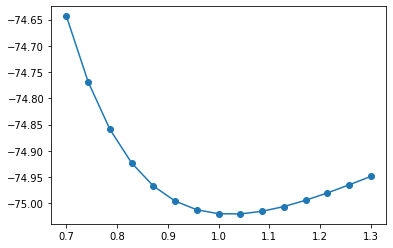

In [8]:
plt.plot( distances, energies, '-o' )

In [9]:
opt, init_state = H2O(operator=True, initial_state=True, remove_orbitals=[4])
opt.num_qubits

8

In [10]:
def GroundStateEigensolver_exact_loop( d ):
    converter, problem = H2O( distance=d, operator=False, remove_orbitals=[4] )
    calc = GroundStateEigensolver( converter, NumPyMinimumEigensolver() )
    res = calc.solve(problem)
    return res.total_energies 

In [11]:
energies2 = Parallel(n_jobs=-1)( delayed(GroundStateEigensolver_exact_loop)(d) for d in distances )

C:\Users\lucia\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


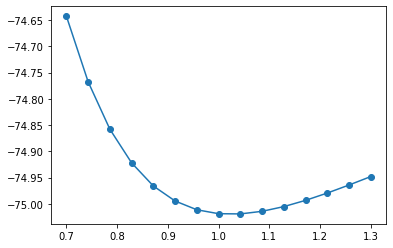

In [12]:
plt.plot( distances, energies2, '-o' )

In [13]:
np.linalg.norm( np.array(energies)-np.array(energies2) )

0.003834422186210097

In [14]:
0.05642773304644712, 0.145930669132429, 0.1054764919488905, 0.0039759107879492415, 0.1466120525852858, 0.15227803832381695

(0.05642773304644712,
 0.145930669132429,
 0.1054764919488905,
 0.0039759107879492415,
 0.1466120525852858,
 0.15227803832381695)

In [15]:
np.array(energies)-np.array(energies2) 

array([[-0.00109257+0.j],
       [-0.00110239+0.j],
       [-0.00110553+0.j],
       [-0.00110203+0.j],
       [-0.00109201+0.j],
       [-0.0010757 +0.j],
       [-0.00105347+0.j],
       [-0.00102582+0.j],
       [-0.00099334+0.j],
       [-0.00095671+0.j],
       [-0.00091661+0.j],
       [-0.00087375+0.j],
       [-0.00082883+0.j],
       [-0.00078247+0.j],
       [-0.00073524+0.j]])